In [23]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time
import matplotlib.pyplot as plt

#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [24]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 20

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 9

# Initialization of the number of iteration
it = 1

# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]


Creating the model variables...
Model variables created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !



Classing solutions...
Le min de list_obj est 696
Le max de list_obj est 771
[696, 703, 707, 716, 703, 703, 716, 696, 703, 696, 703, 707, 716, 703, 703, 716, 696, 771, 710, 771]
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences est cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

Creating the model variables...
Model variables created !

Solver initialized !
Clustering ...
5

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Classing solutions...
Le min de list_obj est 696
Le max de list_obj est 939
[939, 803, 861, 790, 860, 811, 848, 812, 816, 890, 696, 696, 696, 696, 703, 703, 703, 703, 703, 703, 703, 707, 707, 710, 716, 716, 716, 716, 771, 771]
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des pré

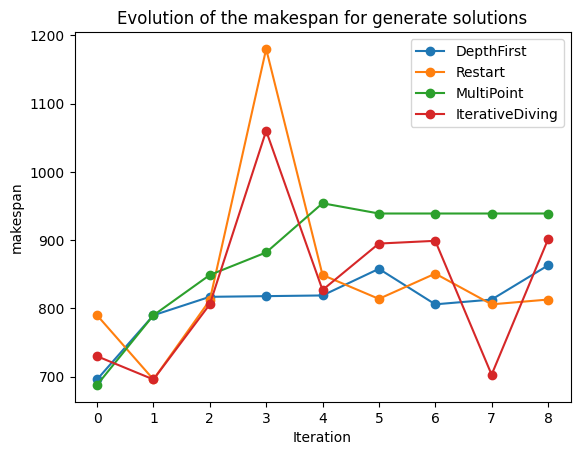

In [25]:
for s_type in list_search_type:
    #############################
    ### Main program ###
    #############################

    # print("\n--------Main program is loading...---------")

    # --------- Interaction with the solver
    data = []
    n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver = fm.initialize_solver(data, n, m, duration)

    # ------------ Solve the model
    # print("\nSolving the model...")
    msol, nb_solution, runtime = solver.solve(model, k, n, m, 0, T_machine, optimalval, s_type)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    # print("Model solved !")

    # ---------------- Interaction with the user
    # print("\n--------Interaction with the user...---------")
    # print("\nCreating the user...")
    user = User()
    # print("User created !")

    #Get the variables of the model
    variables = solver.get_variables()

    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, variables, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

    # print("list layers : ",list_layers)

    ####################################################################
    #### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
    ####################################################################

    import clustering as cl

    ###  -------------- Iteration of the solver with the preferences
    it = 1
    tps = runtime
    list_min_obj = [min(list_obj)]
    list_min_obj_global = [min(list_obj)]

    criterion = (tps < tps_max) and (it < it_max) 

    # ----------------- Add the preferences to the model
    while criterion :
        # print("\n--------Iteration {}---------".format(it))
        it += 1

        # --------- Call Solver constructor in Solver.py and create the variables of the model
        model, solver = fm.initialize_solver(data, n, m, duration)

        # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
        variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
        
        # --------- Add the constraints considering the clustering
        
            #------------------ Layers creation 
        # layers = cl.create_layers(list_equal, matrix)
        layers = cl.create_layers_fixed(list_layers)
        print(len(layers))
        # print(len(layers[i]) for i in range (len(layers)))
            #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
        nb_clusters = fm.choose_best_clusters(layers)

        default_value_rayon = 3 

        for l in range(len(layers)):
            data = layers[l]
            k = nb_clusters[l]

            # print("-------------- Layer", l, "-----------------")
            # print("Number of clusters :", k)
            # print("Number of solutions :", len(data))

            if l > 0:
                #------------------ If there is only one solution in the layer, we add a constraint to the model
                if(len(data)==0):
                    continue
                elif (len(data) == 1):
                    solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >= default_value_rayon + l*l)
                    continue
                else :
                #------------------ Get the average of each cluster
                    k, avg, labels = fm.average_computation(data, k)

                #------------------ Get the solutions which is the closest to the average of each cluster
                    the_ones = fm.solution_average(k, data, labels, avg)
                    
                #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                    #------------------ Liste des solutions des clusters de la layer l

                    for i in range(k):
                        sol_cluster=[]
                        for j in range(len(data)):
                            if labels[j]==i:
                                sol_cluster.append(data[j])
                    #------------------ Ajout des contraintes
                        solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >=  fm.rayon_cluster(the_ones[i], sol_cluster) + l*l)
                

        # ------------ Solve the model
        # print("\nSolving the model...")
        msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval)
        # print("The number of solutions generated is :",nb_solution)
        list = []
        for sol in msol:
            list.append(user.objectiveFunction(sol))

        list_min_obj.append(min(list))
        # print("Objective function :", list_min_obj)

        # ------------ Display the result
        fm.display_solution(msol, display_sol)
        # print("Model solved !")

        # ---------------- Interaction with the user
        list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers)
        # print("Il y a {} solution(s)".format(len(pref)))

        list_min_obj_global.append(min(list_obj))
        # print("Objective function global :", list_min_obj_global)

        # Vector of the start time of each task of each preference
        starts = user.start_pref(n, m, variables, display_start)

        # Matrix of the start time of each task of each preference
        matrix = user.matrix_pref(n, m, display_matrix)

        # Testing the order of preferences and the differences between solutions
        fm.test(n, m, user)

    #------------------ Condition d'arrêt ------------------
        tps += runtime
        criterion = (tps < tps_max) and (it < it_max)
        fm.stopCondition(it, it_max, tps, tps_max)
    # Plot du minimum de l'objectif parmi les nouvelles solutions générées

    print(list_min_obj)
    # print(s_type)
    plt.plot([i for i in range(it)], list_min_obj, label=s_type, marker='o')

plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()

plt.show() 